In [ ]:
# standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
# statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
# os
import os
import sys
# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# tf
import tensorflow as tf
# keras
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Layer, LSTM, GRU, SimpleRNN, Dense, Activation, Bidirectional, Dropout
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras import optimizers
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.regularizers import l1,l2

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Import btc
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Path
path = '/content/gdrive/MyDrive/Colab Notebooks/NN Time Series Project/data'
sys.path.append(path)

In [ ]:
# Import atRNN
from atrnn import AlphatRNN

In [ ]:
# Make pd df
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/NN Time Series Project/data/btc.csv')

In [ ]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Drop extraneous columns
df.drop(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)'], axis = 1, inplace = True)
# Drop bottom 3m rows and top 800k
df.drop(df.index[:3000000], axis = 0, inplace = True)
df.drop(df.index[4000000:], axis = 0, inplace = True)
# Reset index; drop column
df.reset_index(drop = True, inplace = True)
# Backfill na's
df.fillna(method = 'backfill', inplace = True)

In [ ]:
# RNN target/features
features = ['Weighted_Price']
target = 'Weighted_Price'

In [ ]:
# Split train sets
train_weight = 0.8
df_split = int( len(df) * train_weight )

train = df.iloc[:df_split]
test = df.iloc[df_split:]

In [ ]:
# Scaling parameters
mu = float( train[features].mean() )
sigma = float( train[features].std() )

# Scale data
train = train[features].apply( lambda x: (x - mu) / sigma )
test = test[features].apply( lambda x: (x - mu) / sigma )

In [ ]:
'''
Function for reshaping data into one-step ahead time series prediction format
    value: feature value to be lagged
    n_steps: number of steps/sequence length
    n_steps_ahead: forecasting horizon
'''

def get_lagged_features(value, n_steps, n_steps_ahead):
    lag_list = []
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append( value.shift(lag) )
    return pd.concat(lag_list, axis = 1)

In [ ]:
'''
Function for altering train/test time-series into n-step lagged data
    _train: train data
    _test: test data
    n_steps: number of lags
'''

def lag_train_test(_train = train, _test = test, n_steps = 3):
    n_steps_ahead = n_steps

    # Transform training input and output data
    col_ords = []
    for i in range(n_steps):
        for j in range(len(features)):
            col_ords.append(i + j * n_steps)

    x_train_list = []
    for f in features:
        x_train_reg = get_lagged_features(train, n_steps, n_steps).dropna()
        x_train_list.append(x_train_reg)
    x_train_reg = pd.concat(x_train_list, axis = 1)
            
    x_train_reg = x_train_reg.iloc[:, col_ords]
    y_train_reg = train.loc[x_train_reg.index, [target]].values
    x_train_reg = np.reshape( x_train_reg.values, ( x_train_reg.shape[0], int( x_train_reg.shape[1] / len(features)), len(features) ) )
    y_train_reg = np.reshape( y_train_reg, (y_train_reg.shape[0], 1, 1))

    # Transform test input and output data
    x_test_list = []
    for f in features:
        x_test_reg = get_lagged_features(test, n_steps, n_steps).dropna()
        x_test_list.append(x_test_reg)
    x_test_reg = pd.concat(x_test_list, axis = 1)

    x_test_reg = x_test_reg.iloc[:, col_ords]
    y_test_reg = test.loc[x_test_reg.index, [target]].values
    x_test_reg = np.reshape( x_test_reg.values, ( x_test_reg.shape[0], int( x_test_reg.shape[1] / len(features)), len(features) ) )
    y_test_reg = np.reshape( y_test_reg, (y_test_reg.shape[0], 1, 1))

    print('Data transformed to have ' + str(n_steps) + ' step-lags...')
    print('   Regularized x training set shape: ' + str(x_train_reg.shape))
    print('   Regularized x testing set shape: ' + str(x_test_reg.shape))
    print('   Regularized y training set shape: ' + str(y_train_reg.shape))
    print('   Regularized y testing set shape: ' + str(y_test_reg.shape))

    return [x_train_reg, x_test_reg, y_train_reg, y_test_reg]

In [ ]:
# Custom activation function
def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish)})

In [ ]:
# NN structures - SWISH
def _RNN(data = train, n_units = 10, l1_reg = 0.0001, seed = 0, optim = 'adam', dropout = 0):
    model = Sequential()
    model.add( 
        SimpleRNN(n_units,
                  activation = 'swish', 
                  kernel_initializer = keras.initializers.glorot_uniform(seed), 
                  bias_initializer = keras.initializers.glorot_uniform(seed), 
                  recurrent_initializer = keras.initializers.orthogonal(seed), 
                  kernel_regularizer = l1(l1_reg), 
                  input_shape = (data.shape[1], data.shape[-1]),
                  unroll = True,
                  stateful = False) )  
    model.add(
        Dense(1, 
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg) ) )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

def _atRNN(data = train, n_units = 10, l1_reg = 0.0001, seed = 0, optim = 'adam', dropout = 0):
    model = Sequential()
    model.add( 
        AlphatRNN(n_units,
                  activation = 'swish',
                  recurrent_activation = 'sigmoid',
                  kernel_initializer = keras.initializers.glorot_uniform(seed), 
                  bias_initializer = keras.initializers.glorot_uniform(seed), 
                  recurrent_initializer = keras.initializers.orthogonal(seed), 
                  kernel_regularizer = l1(l1_reg), 
                  input_shape = (data.shape[1], data.shape[-1]),
                  unroll = True,
                  stateful = False) )  
    model.add(
        Dense(1, 
              kernel_initializer = keras.initializers.glorot_uniform(seed), 
              bias_initializer = keras.initializers.glorot_uniform(seed), 
              kernel_regularizer = l1(l1_reg) ) )
    model.compile(loss = 'mean_squared_error', optimizer = optim)
    return model

In [ ]:
# Hyperparameters
n_epoches = 50
batch_size = 1000

In [ ]:
# Implement early stopping monitor to speed up cross validation
es = EarlyStopping(monitor = 'loss', mode = 'min', verbose = 1, patience = 100, min_delta = 1e-7, restore_best_weights = True)

In [ ]:
# NN models
params = {
    'srnn_5lag': {'model':'', 'function':_RNN, 'data':[], 'H':10, 'l1_reg':0.0001, 'n_lags':5, 'label':'sRNN - 5', 'history':''},
    'atrnn_3lag': {'model':'', 'function':_atRNN, 'data':[], 'H':8, 'l1_reg':0.0001, 'n_lags':3, 'label':'atRNN - 3', 'history':''},
    'atrnn_5lag': {'model':'', 'function':_atRNN, 'data':[], 'H':8, 'l1_reg':0.0001, 'n_lags':5, 'label':'atRNN - 5', 'history':''},
    'atrnn_7lag': {'model':'', 'function':_atRNN, 'data':[], 'H':8, 'l1_reg':0.0001, 'n_lags':7, 'label':'atRNN - 7', 'history':''}
}

In [ ]:
# Produce lagged data; store in params

for k in params.keys():
    params[k]['data'] = lag_train_test(train, test, params[k]['n_lags'])

Data transformed to have 5 step-lags...
   Regularized x training set shape: (1485892, 5, 1)
   Regularized x testing set shape: (371467, 5, 1)
   Regularized y training set shape: (1485892, 1, 1)
   Regularized y testing set shape: (371467, 1, 1)
Data transformed to have 3 step-lags...
   Regularized x training set shape: (1485896, 3, 1)
   Regularized x testing set shape: (371471, 3, 1)
   Regularized y training set shape: (1485896, 1, 1)
   Regularized y testing set shape: (371471, 1, 1)
Data transformed to have 5 step-lags...
   Regularized x training set shape: (1485892, 5, 1)
   Regularized x testing set shape: (371467, 5, 1)
   Regularized y training set shape: (1485892, 1, 1)
   Regularized y testing set shape: (371467, 1, 1)
Data transformed to have 7 step-lags...
   Regularized x training set shape: (1485888, 7, 1)
   Regularized x testing set shape: (371463, 7, 1)
   Regularized y training set shape: (1485888, 1, 1)
   Regularized y testing set shape: (371463, 1, 1)


In [ ]:
# Train
for k in params.keys():
    tf.random.set_seed(0)
    model = params[k]['function'](params[k]['data'][0], params[k]['H'], params[k]['l1_reg'] )
    params[k]['history'] = model.fit(params[k]['data'][0], params[k]['data'][2], epochs = n_epoches, 
                                     batch_size = batch_size, callbacks = [es], shuffle = False )
    params[k]['model'] = model

Epoch 1/50
1486/1486 [==============================] - 7s 3ms/step - loss: 0.2207
Epoch 2/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0034
Epoch 3/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0013
Epoch 4/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0011
Epoch 5/50
1486/1486 [==============================] - 4s 3ms/step - loss: 9.8004e-04
Epoch 6/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0010
Epoch 7/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0012
Epoch 8/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0014
Epoch 9/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0014
Epoch 10/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0013
Epoch 11/50
1486/1486 [==============================] - 4s 3ms/step - loss: 0.0013
Epoch 12/50
1486/1486 [==============================] - 5s 3ms/step - loss: 0.00

In [ ]:
# Prediction on test and train data with NN models
for k in params.keys():
    step_lag = params[k]['n_lags'] + params[k]['n_lags'] - 1
    model = params[k]['model']
    model.summary()

    params[k]['MSE_train'] = mean_squared_error(train[features][step_lag:], 
                                                model.predict(params[k]['data'][0], verbose = 1))
    params[k]['predict'] = model.predict(params[k]['data'][1], verbose = 1)
    params[k]['MSE_test'] = mean_squared_error(test[features][step_lag:],
                                               params[k]['predict'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
11609/11609 [==============================] - 15s 1ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 alphat_rnn (AlphatRNN)      (None, 8)                 176       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                          

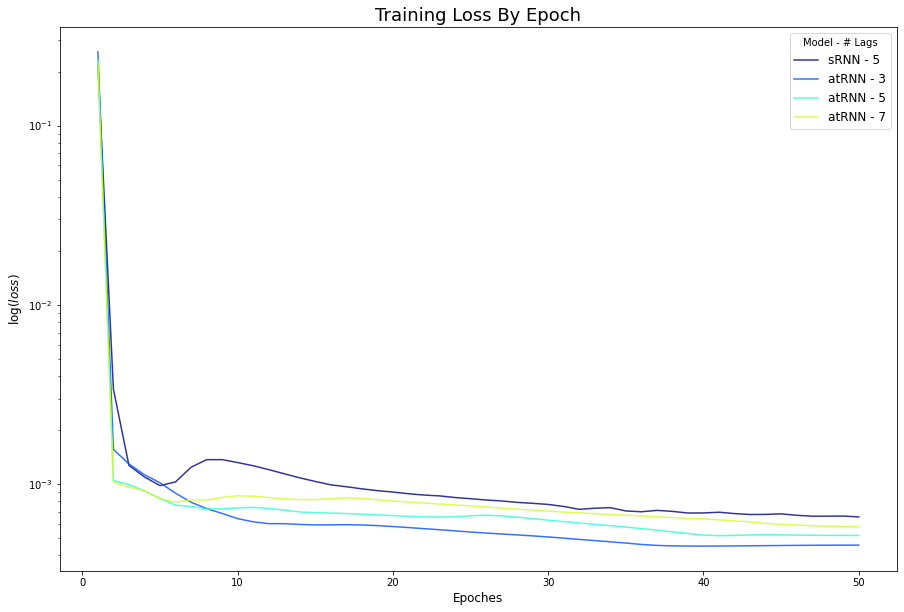

In [ ]:
# Plot training loss by epoch
fig = plt.figure(figsize = (15, 10))
epoch_arr = np.arange(1, n_epoches + 1)
colors = pl.cm.jet(np.linspace(0, 1, 6))
i = 0

for k in params.keys():
    plt.plot(epoch_arr, params[k]['history'].history['loss'], color = colors[i],
             label = params[k]['label'], alpha = 0.8)
    i += 1
    

plt.yscale('log')
plt.legend(loc = 'best', title = 'Model - # Lags', fontsize = 12)
plt.xlabel('Epoches', fontsize = 12)
plt.ylabel('$\log{(loss)}$', fontsize = 12)
plt.title('Training Loss By Epoch', fontsize = 18)

plt.show()

Text(0.5, 1.0, 'Untrimmed Test Residual ($\\hat{Y_i} - Y_i$)')

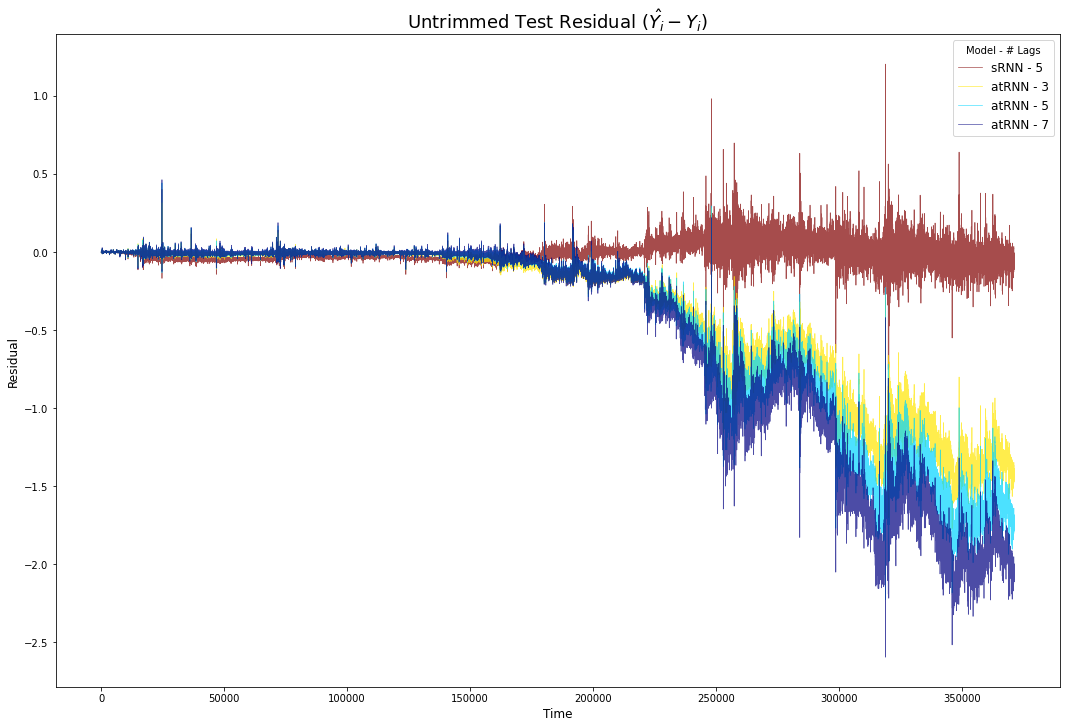

In [ ]:
# Plot untrimmed residuals for test set
test_length = 371457
fig = plt.figure(figsize = (18, 12))
_x = np.arange(0, test_length).reshape(test_length, 1)
colors = pl.cm.jet(np.linspace(1, 0, 4))
i = 0

for k in params.keys():
    residual = params[k]['predict'][:test_length] - params[k]['data'][3][:test_length].reshape(test_length, 1)
    plt.plot(_x, residual, color = colors[i], label = params[k]['label'], alpha = 0.7, linewidth = 0.7)
    i += 1

plt.legend(loc = 'best', title = 'Model - # Lags', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('Untrimmed Test Residual ($\hat{Y_i} - Y_i$)', fontsize = 18)

Text(0.5, 1.0, 'Trimmed Test Residual ($\\hat{Y_i} - Y_i$)')

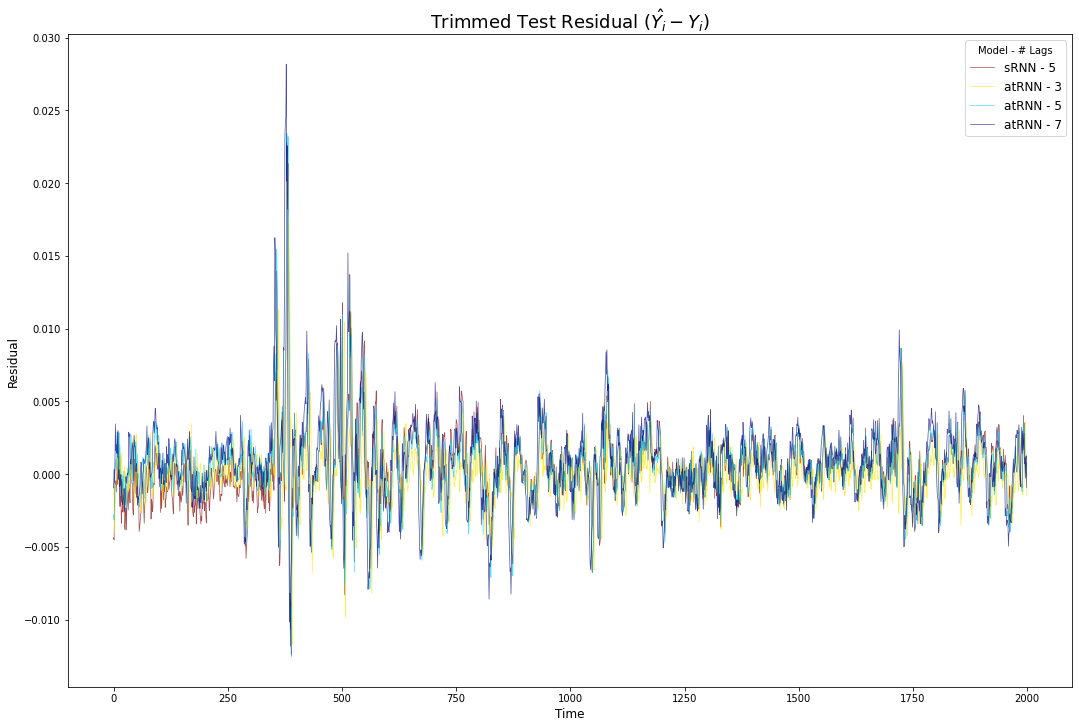

In [ ]:
# Plot trimmed residuals for test set
upper_limit = 2000
fig = plt.figure(figsize = (18, 12))
_x = np.arange(0, upper_limit).reshape(upper_limit, 1)
colors = pl.cm.jet(np.linspace(1, 0, 4))
i = 0

for k in params.keys():
    residual = params[k]['predict'][:upper_limit] - params[k]['data'][3][:upper_limit].reshape(upper_limit, 1)
    plt.plot(_x, residual, color = colors[i], label = params[k]['label'], alpha = 0.7, linewidth = 0.7)
    i += 1

plt.legend(loc = 'best', title = 'Model - # Lags', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('Trimmed Test Residual ($\hat{Y_i} - Y_i$)', fontsize = 18)

Text(0.5, 1.0, 'Near-term Forecasting Residual ($\\hat{Y_i} - Y_i$)')

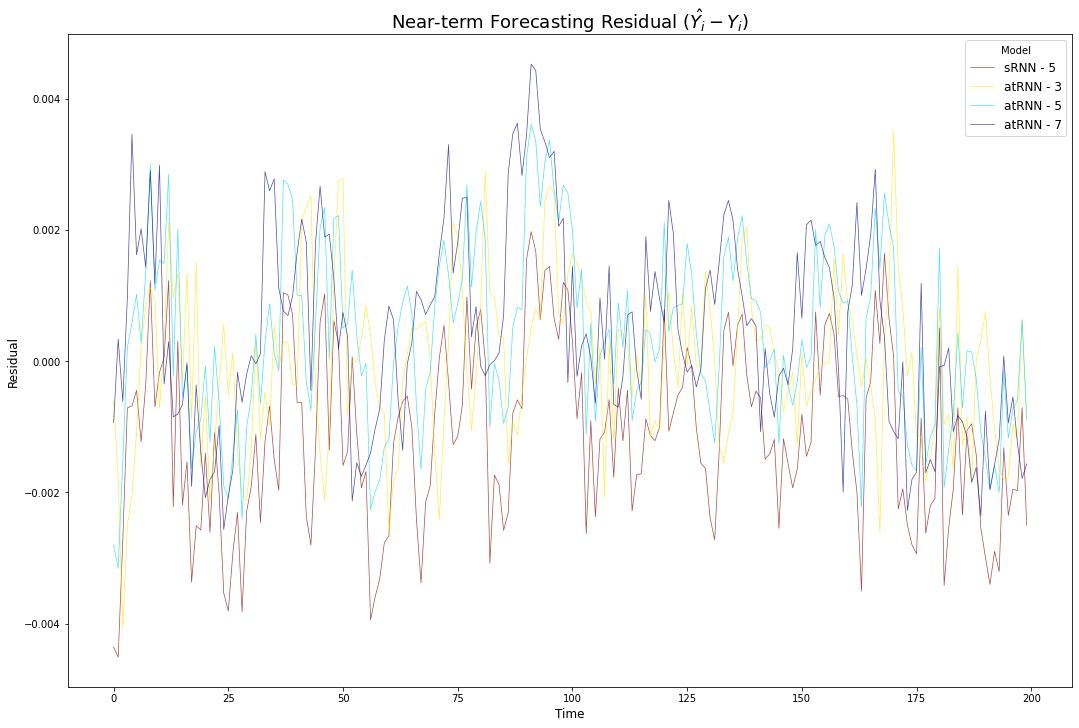

In [ ]:
# Plot near_term forecasting residuals for test set
upper_limit = 200
fig = plt.figure(figsize = (18, 12))
_x = np.arange(0, upper_limit).reshape(upper_limit, 1)
colors = pl.cm.jet(np.linspace(1, 0, 4))
i = 0

for k in params.keys():
    residual = params[k]['predict'][:upper_limit] - params[k]['data'][3][:upper_limit].reshape(upper_limit, 1)
    plt.plot(_x, residual, color = colors[i], label = params[k]['label'], alpha = 0.7, linewidth = 0.7)
    i += 1

plt.legend(loc = 'best', title = 'Model', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Residual', fontsize = 12)
plt.title('Near-term Forecasting Residual ($\hat{Y_i} - Y_i$)', fontsize = 18)

In [ ]:
print("Model Errors by Lag Count:")
print()

for k in params.keys():
    print('Model: ' + params[k]['label'] )
    print('   Lag count - [ ' + str(params[k]['n_lags']) + ' ]')
    print('      Train MSE = ' + str(params[k]['MSE_train']) )
    print('      Test MSE = ' + str(params[k]['MSE_test']) )
    print()

Model Errors by Lag Count:

Model: sRNN - 5
   Lag count - [ 5 ]
      Train MSE = 0.0015648926511321202
      Test MSE = 0.003008651888354583

Model: atRNN - 3
   Lag count - [ 3 ]
      Train MSE = 0.0016202532075737562
      Test MSE = 0.3676450391100329

Model: atRNN - 5
   Lag count - [ 5 ]
      Train MSE = 0.0014931282946763164
      Test MSE = 0.5429933681754268

Model: atRNN - 7
   Lag count - [ 7 ]
      Train MSE = 0.0015540846199139867
      Test MSE = 0.7568930835231049



In [ ]:
# Ljung-box statistic
T = 100000

In [ ]:
for k in params.keys():
    n_steps = params[k]['n_lags']
    residual = test[features][n_steps : (n_steps + T)].values - (sigma * params[k]['predict'][:T, 0] + mu).reshape((T,1))
    lb, p = sm.stats.diagnostic.acorr_ljungbox(residual, lags = 10, boxpierce = False)
    print('Model: %s' % (params[k]['label']))
    print('\t lb: ' + str(lb))
    print('\t p: ' + str(p))

Model: sRNN - 5
	 lb: [ 99994.77774699 199978.32623286 299949.23477387 399907.27382776
 499852.67446495 599785.91050162 699707.48022371 799617.79630849
 899517.16763152 999405.84408729]
	 p: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Model: atRNN - 3
	 lb: [ 99995.15502599 199979.14827872 299950.24471024 399908.45292166
 499854.14122272 599787.80986504 699709.9497789  799620.97921813
 899521.21795493 999410.90451345]
	 p: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Model: atRNN - 5
	 lb: [ 99995.97797228 199982.3421205  299957.15741029 399919.5917423
 499869.56662836 599807.46451354 699733.73004556 799648.75506666
 899552.84943229 999446.25406279]
	 p: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Model: atRNN - 7
	 lb: [ 99996.32576891 199983.73998996 299960.41842236 399925.45210864
 499878.52276452 599819.67618259 699749.17816995 799667.37754096
 899574.57116884 999471.00278709]
	 p: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
#residual=train[features][n_steps:(n_steps + T)].values - (sigma * pred_train[:T, 0]+mu)

In [ ]:
#lb,p=sm.stats.diagnostic.acorr_ljungbox(residual, lags=20, boxpierce=False)